# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,127875690.0,38.119,-54.480,8.96,224,800.0,805.0,1580.9,0,271,0.00000,0.0
1,127875700.0,38.118,-54.489,8.96,224,807.0,801.0,1596.0,0,271,0.00721,10.0
2,127875710.0,38.119,-54.498,8.96,224,813.0,809.0,1593.2,0,271,0.01442,20.0
3,127875720.0,38.119,-54.508,8.96,224,813.0,824.0,1573.0,0,271,0.02163,30.0
4,127875730.0,38.121,-54.515,8.96,224,820.0,825.0,1581.0,0,271,0.02884,40.0


Generate a temperature matrix

In [4]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

## Example with 1st batch of 5 layers

In [14]:
digits_round = 1
x_range = (27, 37)
y_range = (-66, -56)
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
batch1_id = [224, 225, 226, 227, 228]
batch1 = generate_temperature_matrices_v1(df, batch1_id, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_5384\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_5384\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


Plot to see if it works:

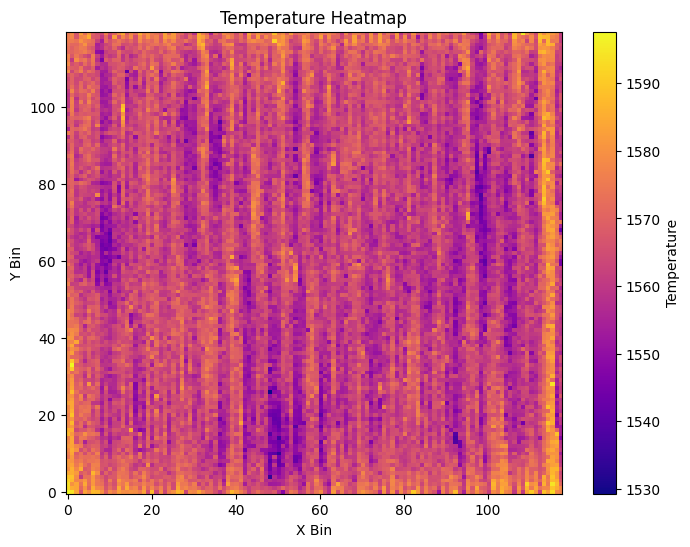

Contains NaN in batch1[0]: False
Contains NaN in batch1[1]: False
Contains NaN in batch1[2]: False
Contains NaN in batch1[3]: False
Contains NaN in batch1[4]: False


In [22]:
plt.figure(figsize=(8, 6))
plt.imshow(batch1[0], origin='lower', cmap='plasma', aspect='auto')
plt.colorbar(label='Temperature')
plt.title('Temperature Heatmap')
plt.xlabel('X Bin')
plt.ylabel('Y Bin')
plt.show()

for i in range(0, 5):
    has_nan = np.isnan(batch1[i]).any()
    print(f"Contains NaN in batch1[{i}]: {has_nan}")

### Apply PCA and compute Hotelling's T²

Reshape the batch for PCA

J = number of layers in the batch (e.g. 5)

M and N = height and width (pixels) of each thermal image

In [27]:
J, M, N = batch1.shape
p = M * N

# Reshape: (J, M, N) → (p, J)
X = batch1.reshape(J, -1).T  # shape: (p, J)
print(X)

[[1597.6  1556.6  1584.5  1585.9  1582.7 ]
 [1594.2  1540.1  1578.8  1587.7  1579.75]
 [1583.8  1535.85 1587.7  1580.2  1578.5 ]
 ...
 [1581.3  1583.45 1576.9  1534.1  1532.3 ]
 [1578.   1591.5  1578.8  1527.8  1532.3 ]
 [1561.05 1589.   1564.9  1530.9  1535.7 ]]


Each row of X corresponds to a single pixel location, showing its thermal profile over time (across the J layers).

Each column represents the thermal value for all pixels at a given layer.

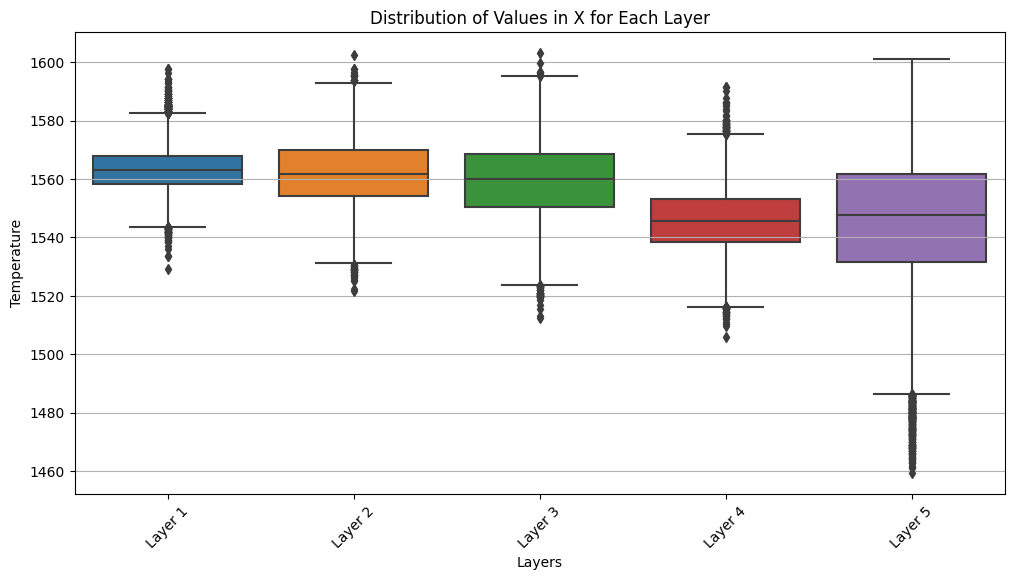

In [31]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Convert X to a DataFrame for easier plotting
X_df = pd.DataFrame(X, columns=[f"Layer {i+1}" for i in range(X.shape[1])])

# Create a boxplot for each column
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_df)
plt.title("Distribution of Values in X for Each Layer")
plt.xlabel("Layers")
plt.ylabel("Temperature")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [43]:
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA, retaining 90% variance
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X)

# Print explained variance ratio to understand the contribution of each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Print the cumulative explained variance to verify 80% variance retention
cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)

# Hotelling's T² calculation
T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
T2_image = T2.reshape(M, N)

Explained Variance Ratio: [0.56129049 0.15990538 0.11692675 0.10667283]
Cumulative Explained Variance: [0.56129049 0.72119587 0.83812262 0.94479545]


### Apply k-means clustering

In [44]:
from sklearn.cluster import KMeans

T2_flat = T2_image.flatten().reshape(-1, 1)
kmeans = KMeans(n_clusters=3, n_init=100, random_state=42)
labels = kmeans.fit_predict(T2_flat)
clustered_image = labels.reshape(M, N)

#### Find K

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def compute_ssw(T2_flat, max_k=5):
    ssw = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
        labels = kmeans.fit_predict(T2_flat)
        centers = kmeans.cluster_centers_
        ssw_k = sum((T2_flat[i] - centers[labels[i]])**2 for i in range(len(T2_flat)))
        ssw.append(ssw_k.sum())
    return ssw

def compute_elbow_point(ssw):
    # line from point 1 to point K
    k_vals = np.arange(1, len(ssw) + 1)
    line_start = np.array([1, ssw[0]])
    line_end = np.array([len(ssw), ssw[-1]])

    def distance_to_line(x, y, start, end):
        # point-line distance formula
        numerator = np.abs((end[1] - start[1]) * x - (end[0] - start[0]) * y +
                           end[0]*start[1] - end[1]*start[0])
        denominator = np.sqrt((end[1] - start[1])**2 + (end[0] - start[0])**2)
        return numerator / denominator

    distances = [distance_to_line(k, ssw_val, line_start, line_end)
                 for k, ssw_val in zip(k_vals, ssw)]

    best_k = k_vals[np.argmax(distances)]
    return best_k, distances

# Flatten T² image
T2_flat = T2_image.flatten().reshape(-1, 1)

# Run SSW and elbow detection
ssw = compute_ssw(T2_flat, max_k=5)
best_k, distances = compute_elbow_point(ssw)

# Plot elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), ssw, 'o-', label='SSW(k)')
plt.xlabel('Number of Clusters k')
plt.ylabel('Sum of Squared Distances (SSW)')
plt.title(f'Elbow Method - Suggested k = {best_k}')
plt.axvline(best_k, color='r', linestyle='--', label='Elbow Point')
plt.legend()
plt.grid(True)
plt.show()

### Plot

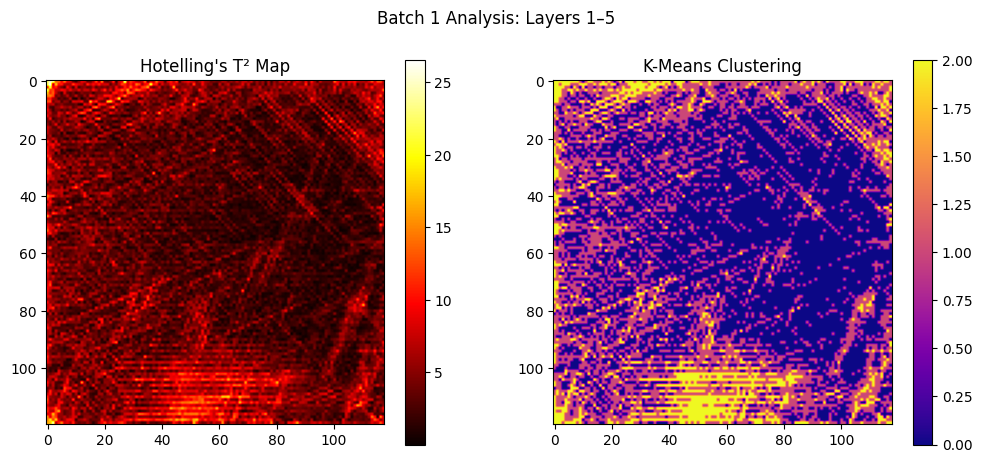

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.suptitle("Batch 1 Analysis: Layers 1–5")

plt.subplot(1, 2, 1)
plt.imshow(T2_image, cmap='hot')
plt.title("Hotelling's T² Map")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(clustered_image, cmap='plasma')
plt.title("K-Means Clustering")
plt.colorbar()
plt.show()

Checking the layers to see if it matches

## Control chart with max T2 (apply to all 5 batches)

In [5]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
batch1_id = [224, 225, 226, 227, 228]
batch2_id = [324, 325, 326, 327, 328]
batch3_id = [424, 425, 426, 427, 428]
batch4_id = [524, 525, 526, 527, 528]
batch5_id = [569, 570, 571, 572, 573]
batch1 = generate_temperature_matrices_v1(df, batch1_id, x_range, y_range, digits_round)
batch2 = generate_temperature_matrices_v1(df, batch2_id, x_range, y_range, digits_round)
batch3 = generate_temperature_matrices_v1(df, batch3_id, x_range, y_range, digits_round)
batch4 = generate_temperature_matrices_v1(df, batch4_id, x_range, y_range, digits_round)
batch5 = generate_temperature_matrices_v1(df, batch5_id, x_range, y_range, digits_round)
batches = [batch1,batch2,batch3,batch4,batch5]

C:\Users\Utente\AppData\Local\Temp\ipykernel_11644\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_11644\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


Collect T² statistics across batches

max(T²) How extreme the hottest point is.

C:\Users\Utente\AppData\Local\Temp\ipykernel_5384\1398304827.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


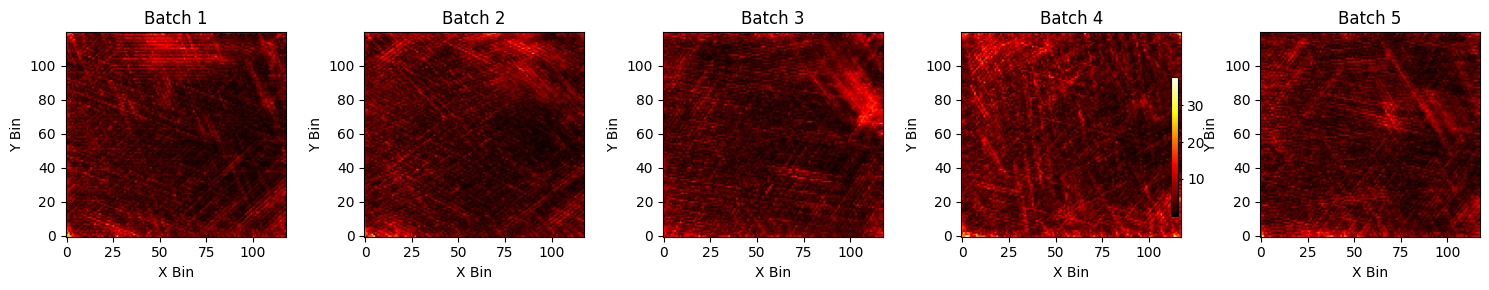

[26.56401316698107, 26.80188495061767, 22.102584748305844, 37.580698725514814, 30.5170516969393]


In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

T2_max_values = []
T2_images = []

# Preprocess batches and compute T² images
for batch in batches:
    J, M, N = batch.shape
    X = batch.reshape(J, -1).T
    pca = PCA(n_components=0.90)
    X_pca = pca.fit_transform(X)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
    T2_image = T2.reshape(M, N)
    T2_images.append(T2_image)
    T2_max_values.append(np.max(T2_image))

# Global color scale
vmin = min(np.min(img) for img in T2_images)
vmax = max(np.max(img) for img in T2_images)

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1 row, 5 columns

for i, ax in enumerate(axes):
    im = ax.imshow(T2_images[i], origin='lower', cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
    ax.set_title(f'Batch {i+1}')
    ax.set_xlabel('X Bin')
    ax.set_ylabel('Y Bin')

# Shared colorbar
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.tight_layout()
plt.show()

print(T2_max_values)


MISSING: CHECK ASSUMPTIONS OF CC (NORMALITY AND INDEPENDENCE)

Estimated Location (μ): 26.292600458352567
Estimated Scale (β): 4.136019287727706
LCL: 18.4828523167912
UCL: 53.61917775972816


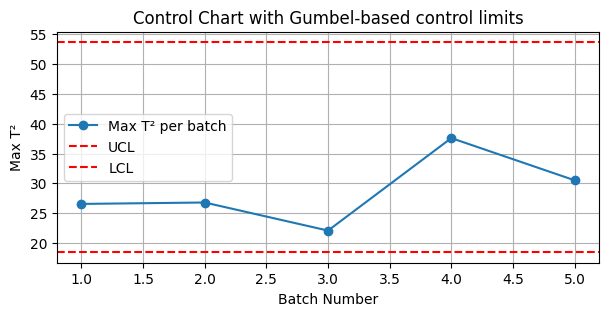

In [69]:
import numpy as np
from scipy.stats import gumbel_r

# Fit Gumbel (extreme value type I, for maxima)
params = gumbel_r.fit(T2_max_values)
mu, beta = params

# Compute control limits (approx. 3-sigma equivalent)
LCL = gumbel_r.ppf(0.00135, loc=mu, scale=beta)
UCL = gumbel_r.ppf(0.99865, loc=mu, scale=beta)

print(f"Estimated Location (μ): {mu}")
print(f"Estimated Scale (β): {beta}")
print(f"LCL: {LCL}")
print(f"UCL: {UCL}")

plt.figure(figsize=(7, 3))
plt.plot(range(1, len(T2_max_values) + 1), T2_max_values, marker='o', label='Max T² per batch')
plt.axhline(UCL, color='red', linestyle='--', label='UCL')
plt.axhline(LCL, color='red', linestyle='--', label='LCL')
plt.title("Control Chart with Gumbel-based control limits")
plt.xlabel("Batch Number")
plt.ylabel("Max T²")
plt.legend()
plt.grid(True)
plt.show()

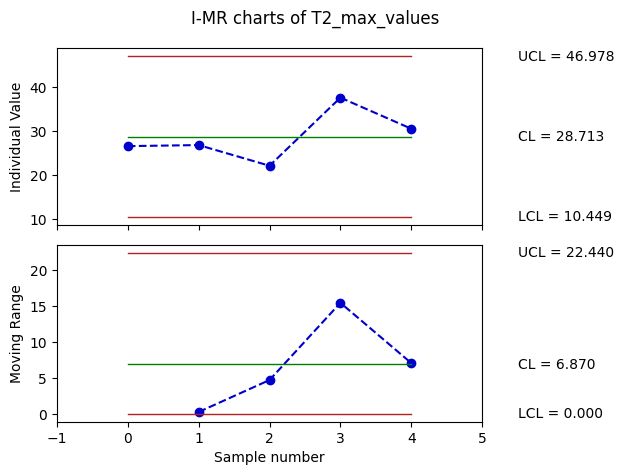

In [63]:
import qdatoolkit as qda

T2_max_values = pd.DataFrame({'T2_max_values': [26.56401316698107, 26.80188495061767, 22.102584748305844, 37.580698725514814, 30.5170516969393]})
data_IMR = qda.ControlCharts.IMR(T2_max_values,'T2_max_values')

## Control chart Based on Defect Area

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

def compute_defect_area(batch, n_clusters=3):
    J, M, N = batch.shape
    X = batch.reshape(J, -1).T

    # PCA
    pca = PCA(n_components=0.90)
    X_pca = pca.fit_transform(X)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
    T2_image = T2.reshape(M, N)

    # Clustering
    T2_flat = T2_image.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
    labels = kmeans.fit_predict(T2_flat)
    clustered_image = labels.reshape(M, N)

    # Determine which cluster is the 'defect cluster' (highest average T²)
    cluster_means = [T2_flat[labels == i].mean() for i in range(n_clusters)]
    defect_cluster_id = np.argmax(cluster_means)
    print(defect_cluster_id)

    # Plot
    plt.figure(figsize=(3, 3))
    plt.imshow(clustered_image, cmap='plasma')
    # Create a legend with cluster labels and corresponding colors
    unique_labels = np.unique(labels)
    colors = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))
    legend_patches = [Patch(color=colors[i], label=f'Cluster {label}') for i, label in enumerate(unique_labels)]
    plt.legend(handles=legend_patches, loc='upper right', title='Clusters')
    plt.title("Clustered Batch")
    plt.show()

    # Count pixels in defect cluster (area)
    defect_area = np.sum(labels == defect_cluster_id)

    return defect_area


In [25]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

def compute_defect_area(batch, n_clusters=3):
    J, M, N = batch.shape
    X = batch.reshape(J, -1).T

    # PCA
    pca = PCA(n_components=0.90)
    X_pca = pca.fit_transform(X)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0))**2, axis=1)
    T2_image = T2.reshape(M, N)

    # Clustering
    T2_flat = T2_image.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
    labels = kmeans.fit_predict(T2_flat)
    clustered_image = labels.reshape(M, N)

    # Determine which cluster is the 'defect cluster' (highest average T²)
    cluster_means = [T2_flat[labels == i].mean() for i in range(n_clusters)]
    sorted_cluster_ids = np.argsort(cluster_means)  # Ascending order: coldest to hottest
    cold_cluster_id = sorted_cluster_ids[0]
    defect_cluster_id = sorted_cluster_ids[-1] # last element

    print(f"Hot cluster id: {defect_cluster_id}")
    print(f"Cold cluster id: {cold_cluster_id}")

    # Assign RGB colors: blue (cold), yellow (mid), red (hot)
    color_map = {
        sorted_cluster_ids[0]: (0, 0, 1),     # Blue
        sorted_cluster_ids[1]: (1, 1, 0),     # Yellow
        sorted_cluster_ids[2]: (1, 0, 0),     # Red
    }

    # Create RGB image
    rgb_image = np.zeros((M, N, 3))
    for cluster_id, color in color_map.items():
        rgb_image[clustered_image == cluster_id] = color

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(rgb_image)
    plt.title("Clustered Image with Temperature Map")

    # Legend
    legend_elements = [
        Patch(facecolor='blue', label='Coldest Cluster'),
        Patch(facecolor='yellow', label='Medium Cluster'),
        Patch(facecolor='red', label='Hottest Cluster')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.axis('off')
    plt.show()

    # Count pixels in defect cluster (area)
    defect_area = np.sum(labels == defect_cluster_id)

    return defect_area


Hot cluster id: 2
Cold cluster id: 0


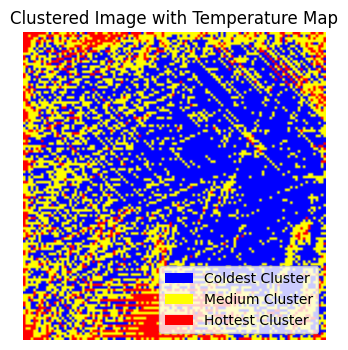

Hot cluster id: 1
Cold cluster id: 0


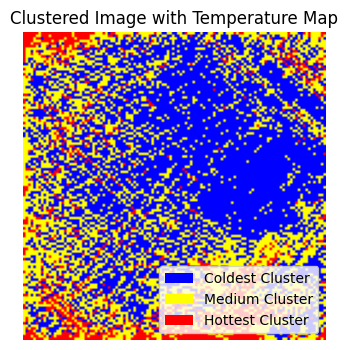

Hot cluster id: 1
Cold cluster id: 0


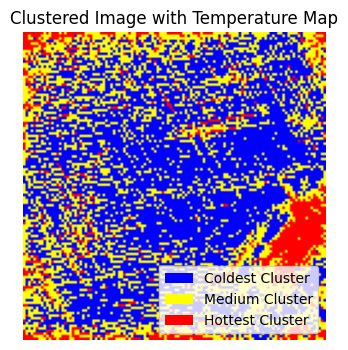

Hot cluster id: 2
Cold cluster id: 0


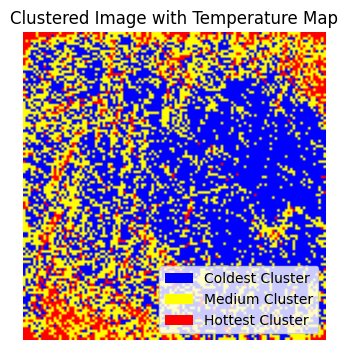

Hot cluster id: 2
Cold cluster id: 1


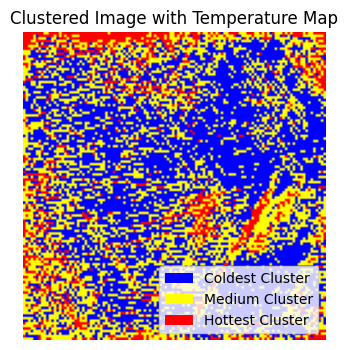

[1483, 1550, 1403, 1393, 1633]


In [26]:
defect_areas = [compute_defect_area(batch) for batch in batches]
print(defect_areas)

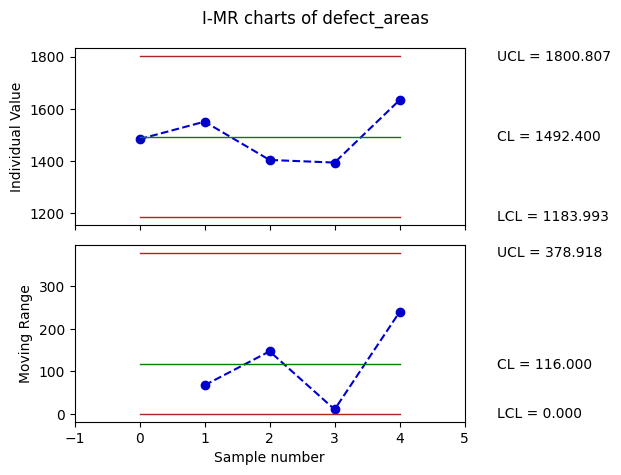

In [28]:
import qdatoolkit as qda


defect_areas = pd.DataFrame({'defect_areas': defect_areas})
data_IMR = qda.ControlCharts.IMR(defect_areas,'defect_areas')